<!-- <a href="https://colab.research.google.com/github/syamkakarla98/Satellite_Imagery_Analysis/blob/main/Classification/Land_Cover_Classification_in_Satellite_Imagery_using_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> -->

# <font color='tomato'>Land Cover Classification in Satellite Imagery using Python</font>

# Import Modules

In [ ]:
# install all the related packages
%pip install earthpy
%pip install rasterio
%pip install sklearn
%pip install matplotlib
%pip install numpy
%pip install scipy
%pip install plotly

In [3]:
from glob import glob

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.plot import show
from rasterio.plot import reshape_as_raster, reshape_as_image

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

from scipy.io import loadmat
from sklearn.metrics import classification_report, accuracy_score

import plotly.graph_objects as go

# np.seterr(divide='ignore', invalid='ignore')

# Read Data

In [4]:
S_sentinel_bands = glob("Data/sundarbans_data/*B?*.tiff")
S_sentinel_bands.sort()
S_sentinel_bands

['Data/sundarbans_data\\2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B01_(Raw).tiff',
 'Data/sundarbans_data\\2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B02_(Raw).tiff',
 'Data/sundarbans_data\\2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B03_(Raw).tiff',
 'Data/sundarbans_data\\2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B04_(Raw).tiff',
 'Data/sundarbans_data\\2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B05_(Raw).tiff',
 'Data/sundarbans_data\\2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B06_(Raw).tiff',
 'Data/sundarbans_data\\2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B07_(Raw).tiff',
 'Data/sundarbans_data\\2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B08_(Raw).tiff',
 'Data/sundarbans_data\\2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B09_(Raw).tiff',
 'Data/sundarbans_data\\2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B11_(Raw).tiff',
 'Data/sundarbans_data\\2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B12_(Raw).tiff',
 'Data/sun

In [31]:
l = []
for i in S_sentinel_bands:
  with rio.open(i, 'r') as f:
    l.append(f.read(1))

arr_st = np.stack(l)
arr_st

array([[[4954, 4863, 4797, ...,    0,    0,    0],
        [5020, 4941, 4882, ...,    0,    0,    0],
        [5046, 4974, 4922, ...,    0,    0,    0],
        ...,
        [   0,    0,    0, ...,    0,    0,    0],
        [   0,    0,    0, ...,    0,    0,    0],
        [   0,    0,    0, ...,    0,    0,    0]],

       [[5453, 4692, 4784, ...,    0,    0,    0],
        [5544, 5564, 5564, ...,    0,    0,    0],
        [5243, 5112, 5459, ...,    0,    0,    0],
        ...,
        [   0,    0,    0, ...,    0,    0,    0],
        [   0,    0,    0, ...,    0,    0,    0],
        [   0,    0,    0, ...,    0,    0,    0]],

       [[8297, 7523, 6960, ...,    0,    0,    0],
        [8480, 7340, 7523, ...,    0,    0,    0],
        [8257, 7956, 7156, ...,    0,    0,    0],
        ...,
        [   0,    0,    0, ...,    0,    0,    0],
        [   0,    0,    0, ...,    0,    0,    0],
        [   0,    0,    0, ...,    0,    0,    0]],

       ...,

       [[3539, 3093, 431

In [7]:
print(f'Height: {arr_st.shape[1]}\nWidth: {arr_st.shape[2]}\nBands: {arr_st.shape[0]}')

Height: 954
Width: 298
Bands: 12


# Visualize the Data

## Bands

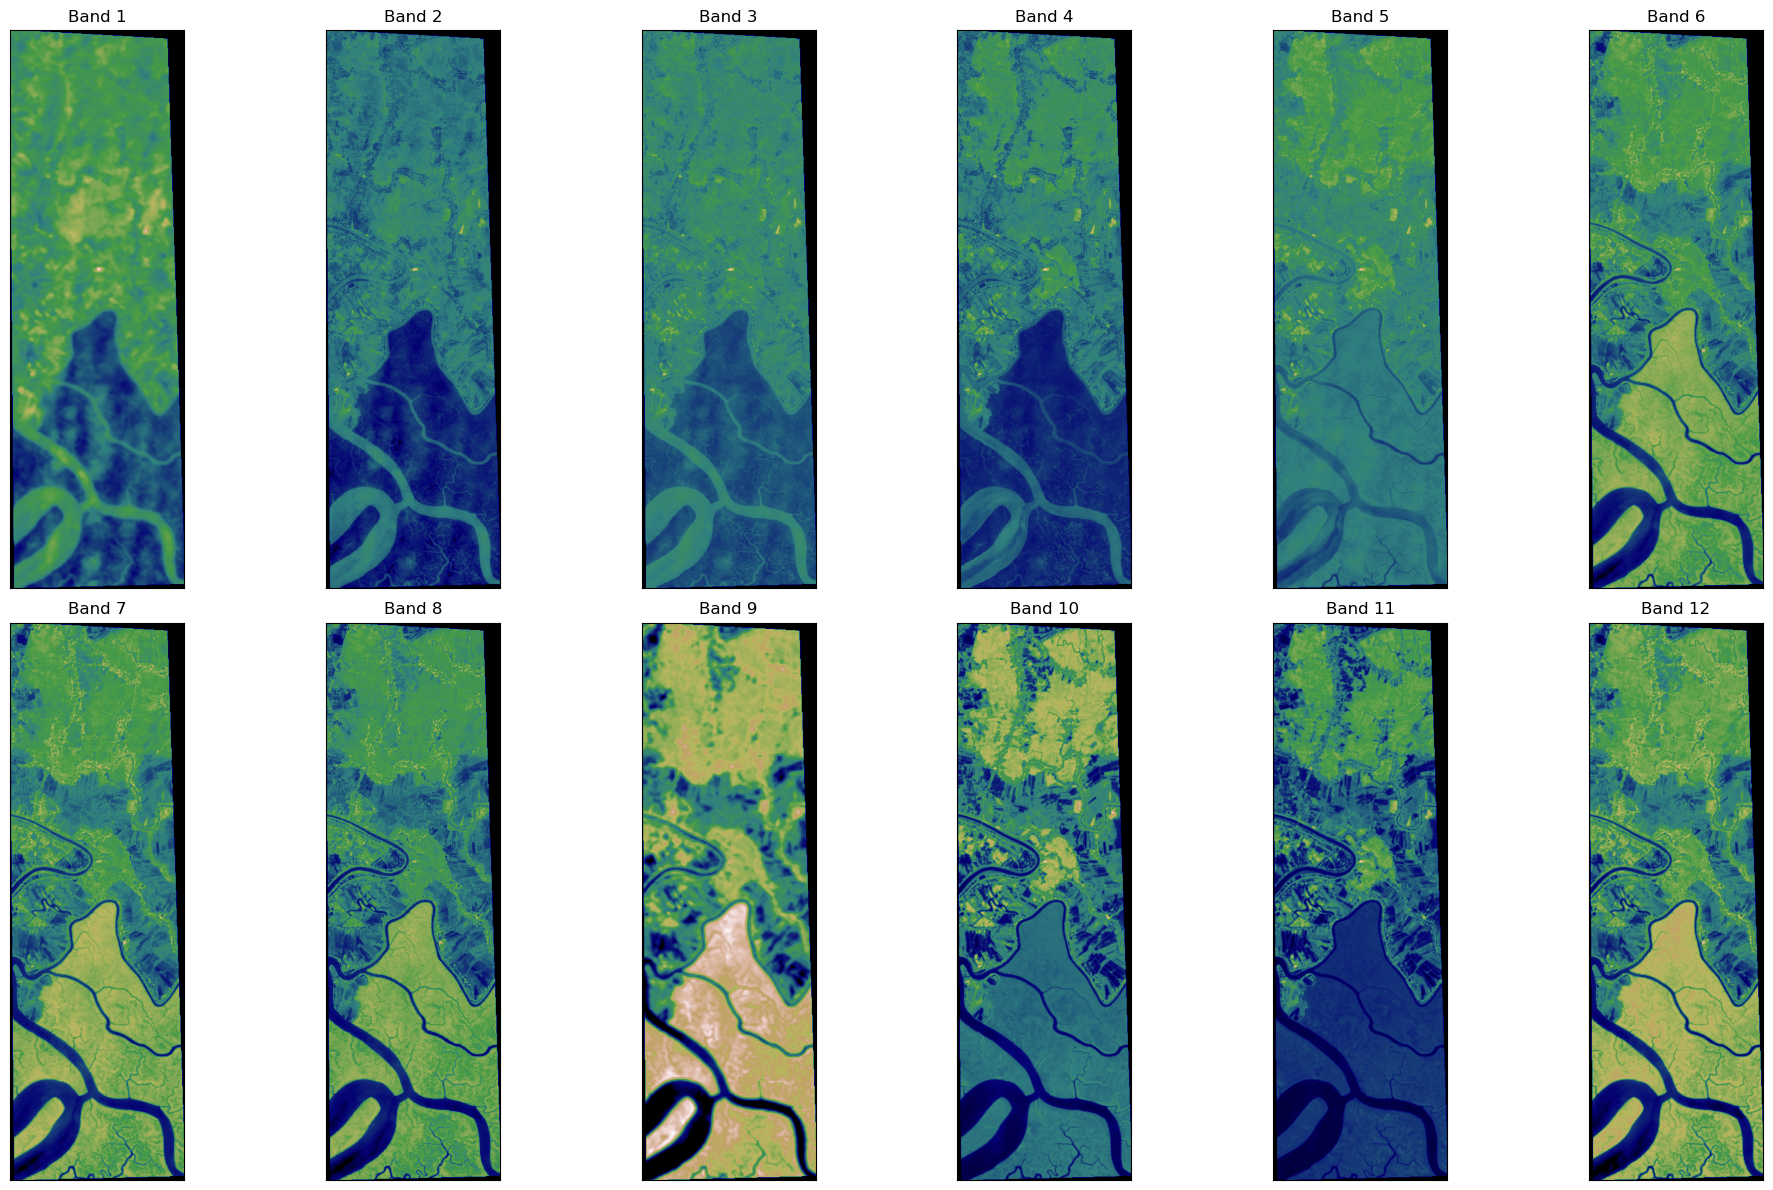

In [8]:
ep.plot_bands(arr_st, cmap = 'gist_earth', figsize = (20, 12), cols = 6, cbar = False)
plt.show()

## RGB Composite Image

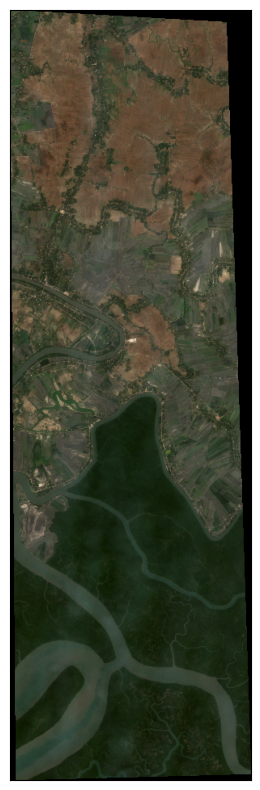

In [26]:
rgb = ep.plot_rgb(arr_st, 
                  rgb=(3,2,1), 
                  figsize=(8, 10), 
                  # title='RGB Composite Image'
                  )

plt.show()

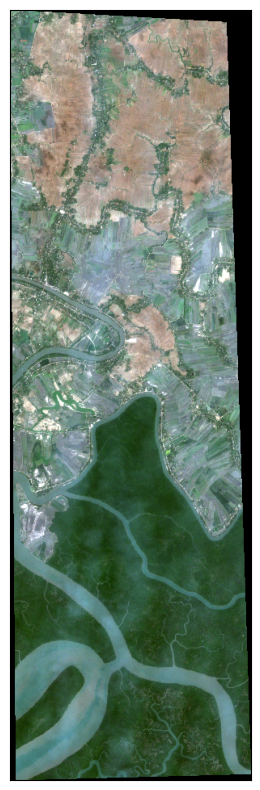

In [10]:
ep.plot_rgb(
    arr_st,
    rgb=(3, 2, 1),
    stretch=True,
    str_clip=0.2,
    figsize=(8, 10),
    # title="RGB Composite Image with Stretch Applied",
)

plt.show()

## Data Distribution of Bands

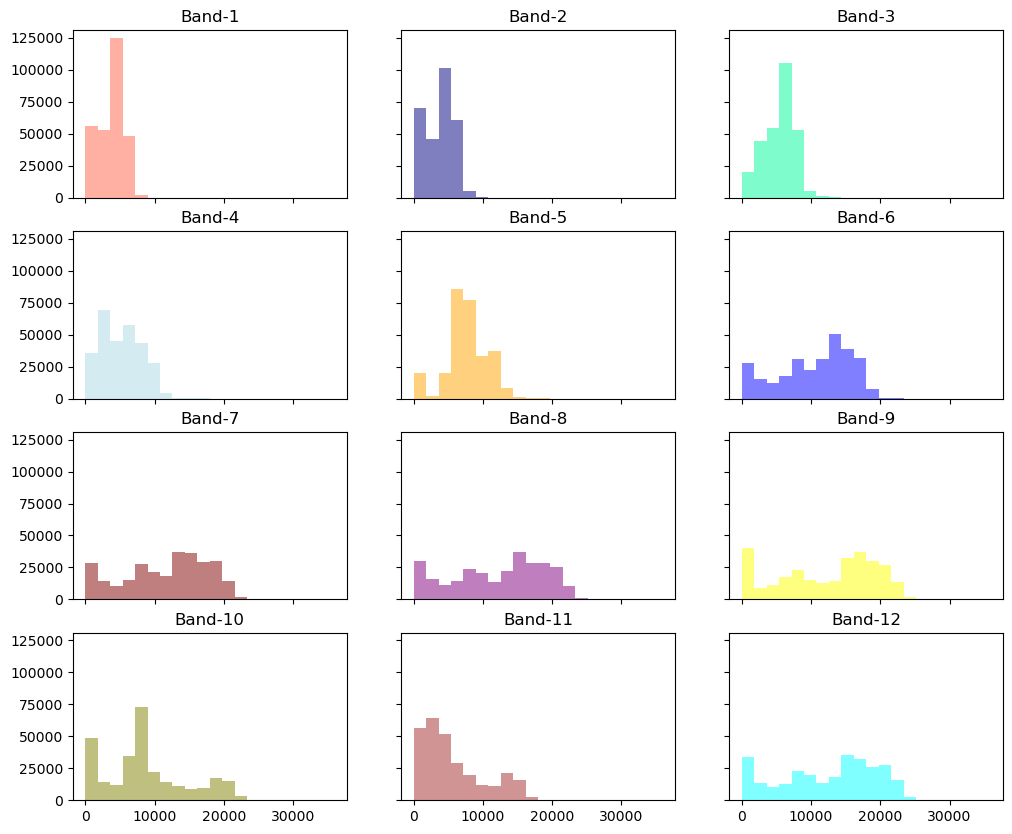

In [28]:
colors = ['tomato', 'navy', 'MediumSpringGreen', 'lightblue', 'orange', 'blue',
          'maroon', 'purple', 'yellow', 'olive', 'brown', 'cyan']

ep.hist(arr_st, 
        colors = colors,
        title=[f'Band-{i}' for i in range(1, 13)], 
        cols=3, 
        alpha=0.5, 
        figsize = (12, 10)
        )

plt.show()

# Preprocessing

In [27]:
print(arr_st.shape)
x = np.moveaxis(arr_st, 0, -1)
x.shape

(12, 954, 298)


(954, 298, 12)

## Scaling

In [29]:
from sklearn.preprocessing import StandardScaler

X_data = x.reshape(-1, 12)

scaler = StandardScaler().fit(X_data)

X_scaled = scaler.transform(X_data)

X_scaled.shape

(284292, 12)

## Load Groundtrue data

In [14]:
y_data = loadmat('Data/sundarbans_data/Sundarbands_gt.mat')['gt']
y_data.shape

(954, 298)

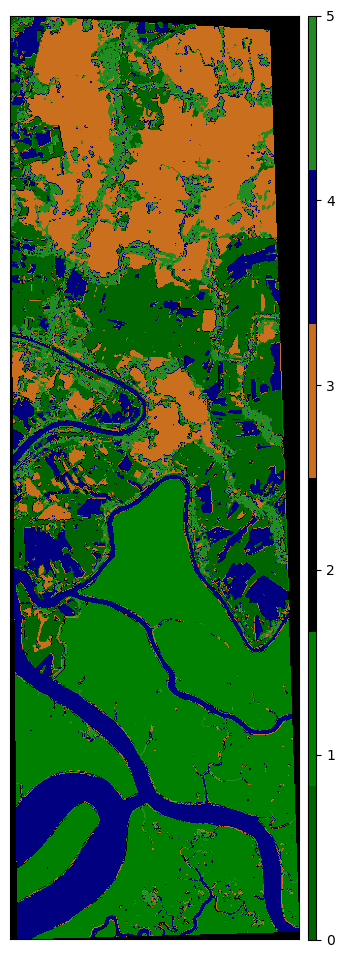

In [40]:
# Visualize Groundtruth
ep.plot_bands(y_data, cmap=ListedColormap(['darkgreen', 'green', 'black', '#CA6F1E', 'navy', 'forestgreen']))
plt.show()

# Train Test Split

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_data.ravel(), test_size=0.30, stratify = y_data.ravel())

print(f'X_train Shape: {X_train.shape}\nX_test Shape: {X_test.shape}\ny_train Shape: {y_train.shape}\ny_test Shape:{y_test.shape}')

X_train Shape: (199004, 12)
X_test Shape: (85288, 12)
y_train Shape: (199004,)
y_test Shape:(85288,)


## K-Mean Classifier (K-Mean)

In [21]:
# use k-mean to cluster the data
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=6, random_state=0).fit(X_train)
kmeans.fit(X_train, y_train)

kmeans.pred = kmeans.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, kmeans.pred)*100}")

print(classification_report(y_test, kmeans.pred))

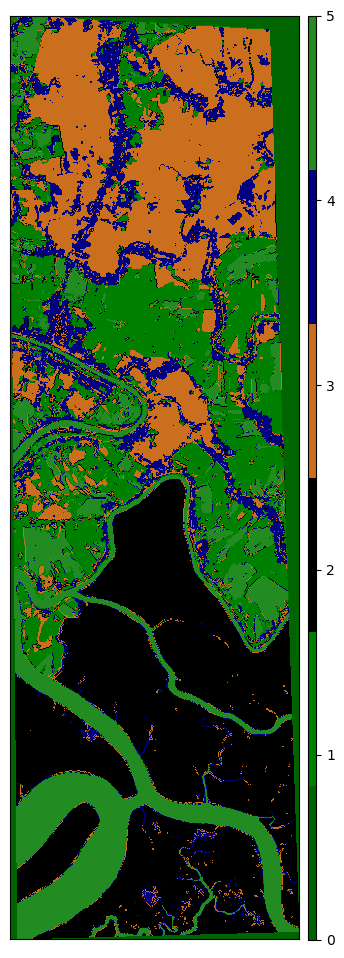

In [24]:
# Visualize Classification Map of K-Means

ep.plot_bands(kmeans.predict(X_scaled).reshape((954, 298)), 
              cmap=ListedColormap(['darkgreen', 'green', 'black', 
                                   '#CA6F1E', 'navy', 'forestgreen']))
plt.show()

## K-Nearest Neighbor Classifier (K-NNC)

In [34]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train, y_train)

knn_pred = knn.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, knn_pred)*100}")

print(classification_report(y_test, knn_pred))

## Compare the predicted results with the groundtruth

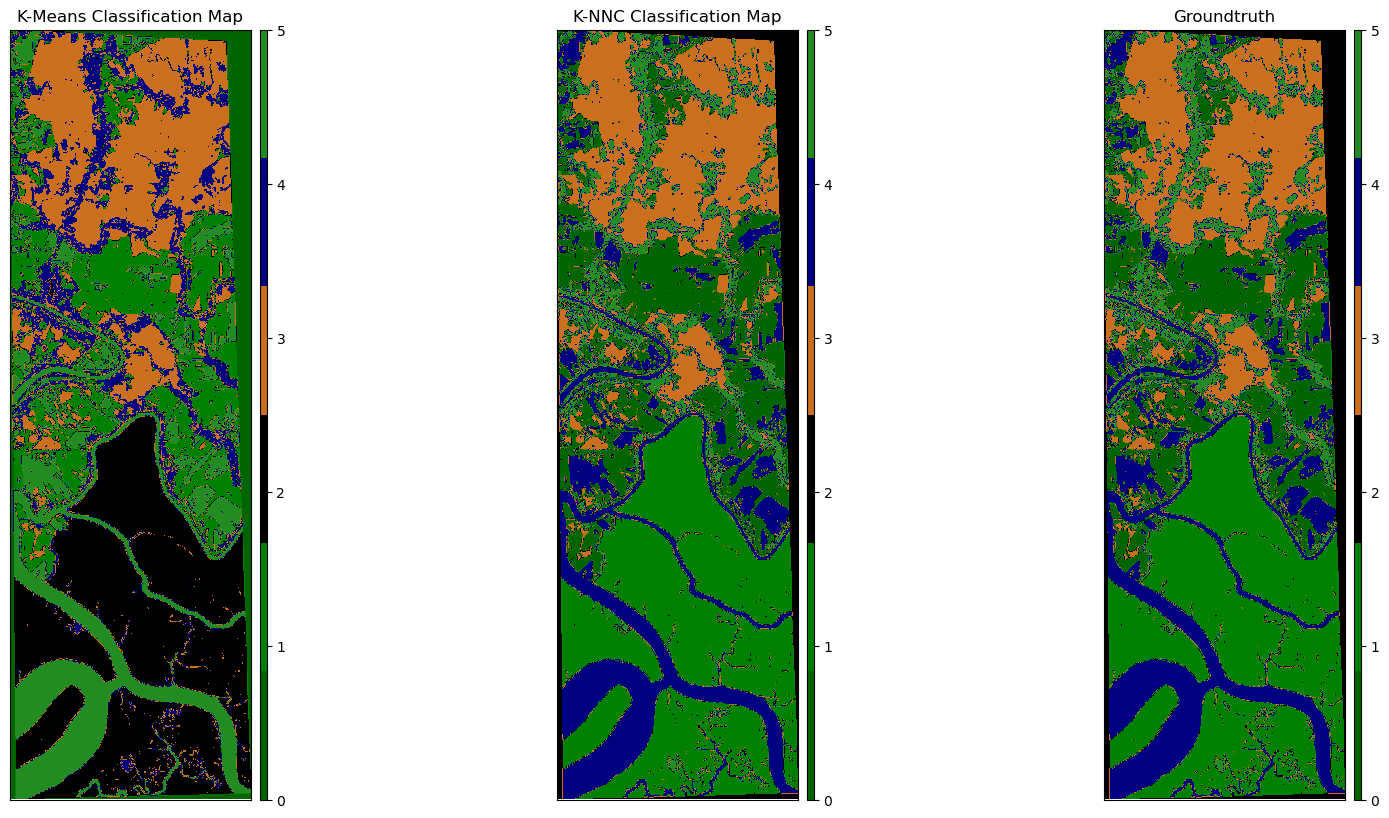

In [41]:
# Compare the predicted results with the groundtruth

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))

ep.plot_bands(kmeans.predict(X_scaled).reshape((954, 298)), 
              cmap=ListedColormap(['darkgreen', 'green', 'black', 
                                   '#CA6F1E', 'navy', 'forestgreen']),
              ax=ax1)

ep.plot_bands(knn.predict(X_scaled).reshape((954, 298)),
                cmap=ListedColormap(['darkgreen', 'green', 'black', 
                                     '#CA6F1E', 'navy', 'forestgreen']),
                ax=ax2)

ep.plot_bands(y_data,
                cmap=ListedColormap(['darkgreen', 'green', 'black', 
                                     '#CA6F1E', 'navy', 'forestgreen']),
                ax=ax3)

ax1.set_title('K-Means Classification Map')
ax2.set_title('K-NNC Classification Map')
ax3.set_title('Groundtruth')

plt.show()

# THE END



---

